# Import thư viện

In [15]:
# Đọc dữ liệu đã tiền xử lý
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu

In [16]:
df = pd.read_csv('./data/weather_preprocessed.csv')
print(f"Đã load dữ liệu: {df.shape[0]} dòng, {df.shape[1]} cột")

Đã load dữ liệu: 25766 dòng, 29 cột


## VI. Research Questions & Analysis
Dựa trên dữ liệu thu thập được, nhóm đặt ra 4 câu hỏi nghiên cứu mang tính thực tiễn để khai thác giá trị của bộ dữ liệu thời tiết. Ngoài ra có thêm 2 câu hỏi về phần model được trình bày trong file 02_modeling.ipynb

## Question 1: Đánh giá Tiềm năng Năng lượng Tái tạo (Điện mặt trời & Điện gió) tại Việt Nam
**1. The Question**
"Sự phân bố tiềm năng năng lượng Mặt trời (dựa trên chỉ số UV, giờ nắng) và năng lượng Gió thay đổi như thế nào giữa các vùng miền và địa hình tại Việt Nam? Đâu là khu vực tối ưu để đầu tư cho từng loại hình năng lượng?"

**2. Motivation & Benefits**
Lý do: Việt Nam đang trong giai đoạn chuyển đổi xanh, nhu cầu tìm kiếm các vùng địa lý tối ưu cho Solar Farm (Điện mặt trời) và Wind Farm (Điện gió) là rất lớn.

Lợi ích:

- Xác định được "vùng vàng" cho điện mặt trời (nơi có UV cao, mây ít) và điện gió (gió mạnh, ổn định).

- Hỗ trợ ra quyết định cho các nhà quy hoạch năng lượng hoặc nhà đầu tư cá nhân (lắp điện áp mái).

- Stakeholders: Bộ Công Thương, Nhà đầu tư năng lượng, Hộ gia đình.

### A. Preprocessing
Để so sánh tiềm năng, chúng ta cần:

- Làm sạch: Loại bỏ các giá trị nhiễu (nếu có) của 'day.uv' và 'day.maxwind_kph'.

- Tạo chỉ số tổng hợp (**Composite Score**):

    - Solar Score: Dựa trên 'day.uv' và 'daylight_duration' (đã tính ở phần trước).

    - Wind Score: Dựa trên day.maxwind_kph.

- Gộp nhóm: Tính trung bình theo location.region và location.terrain để thấy xu hướng vĩ mô.

In [17]:
# 1. Feature Engineering: Tạo cột 'Solar Potential' và 'Wind Potential'
# Giả định đơn giản: Solar Potential tỉ lệ thuận với UV * Giờ nắng
# Wind Potential tỉ lệ thuận với tốc độ gió tối đa

# Normalize dữ liệu về thang 0-1 để dễ so sánh giữa các vùng
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Tạo bản sao để phân tích
energy_df = df.copy()

# Tính toán chỉ số thô
energy_df['raw_solar'] = energy_df['day.uv'] * energy_df['daylight_duration']
energy_df['raw_wind'] = energy_df['day.maxwind_kph']

# Chuẩn hóa về thang điểm 100 cho dễ hiểu
energy_df['Solar_Score'] = normalize(energy_df['raw_solar']) * 100
energy_df['Wind_Score'] = normalize(energy_df['raw_wind']) * 100

### B. Analysis
- Phương pháp: Sử dụng thống kê mô tả (Descriptive Statistics) kết hợp gom nhóm (Aggregation) theo Vùng miền.

Trực quan hóa:

    - Sử dụng Heatmap để hiển thị Tiềm năng Mặt trời theo Vùng và Tháng (để xem tính mùa vụ).

    - Sử dụng Grouped Bar Chart để so sánh trực diện tiềm năng Gió giữa các vùng địa hình (Đồng bằng, Miền núi, Ven biển).

In [18]:
# 1. Aggregation: Tính trung bình Score theo Vùng và Tháng
# Tạo bảng Pivot cho Solar Score
solar_pivot = energy_df.pivot_table(
    index='location.region', 
    columns='month', 
    values='Solar_Score', 
    aggfunc='mean'
)

# 2. Aggregation: Tính trung bình Wind Score theo Vùng
wind_region = energy_df.groupby('location.region')['Wind_Score'].mean().sort_values(ascending=False)

### C. Results & Interpretation

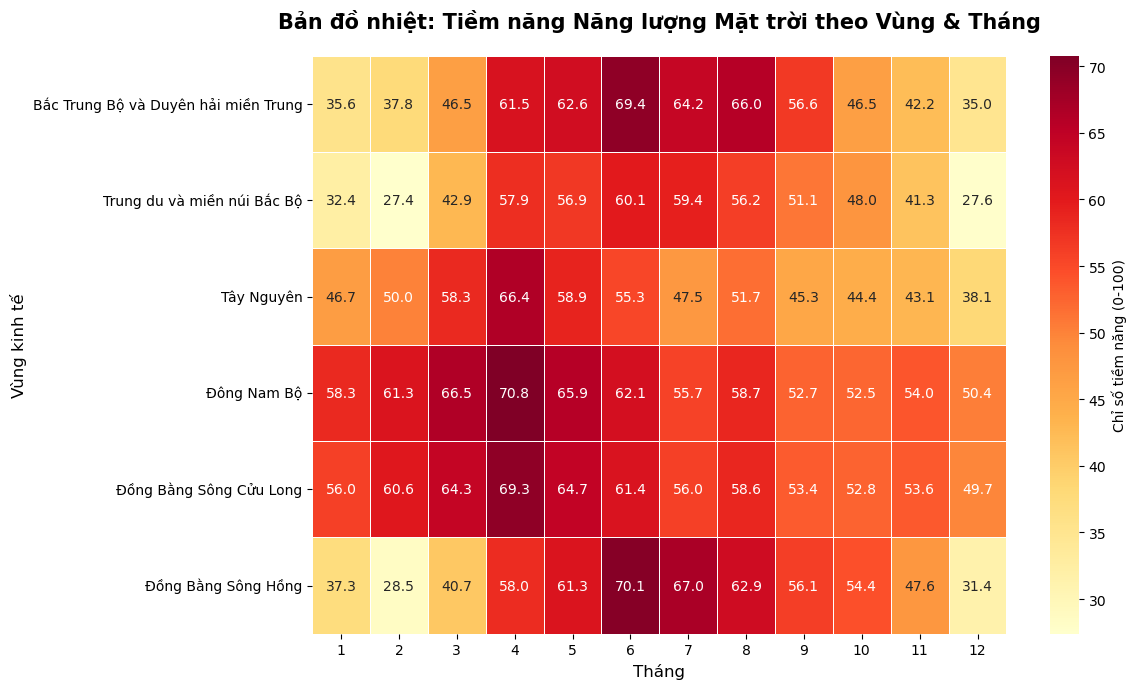

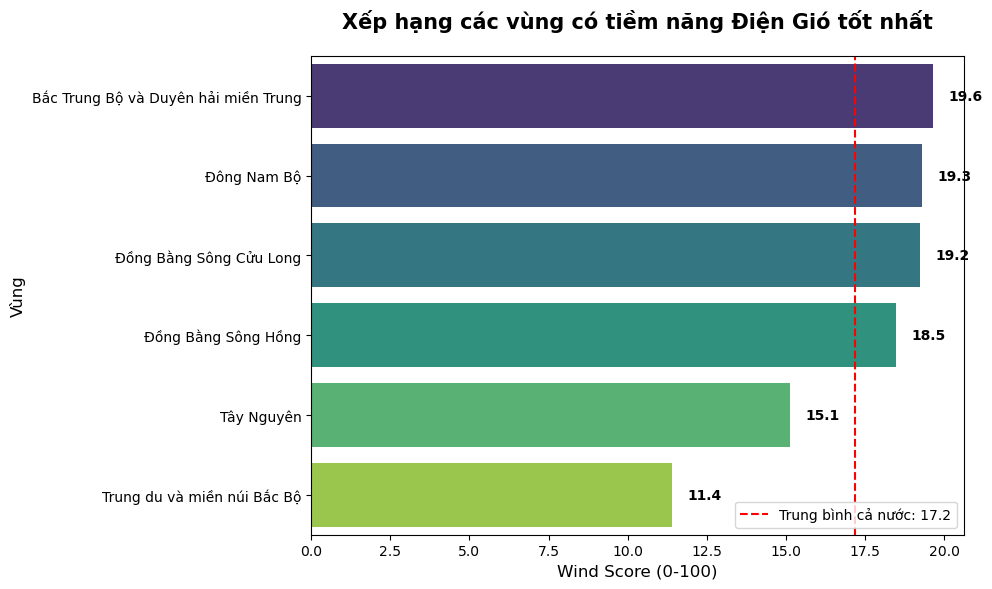

In [19]:
# BIỂU ĐỒ 1: HEATMAP TIỀM NĂNG ĐIỆN MẶT TRỜI
# Tăng chiều rộng lên 12 để các ô heatmap và nhãn tháng (1-12) có đủ không gian hiển thị
plt.figure(figsize=(12, 7)) 

sns.heatmap(
    solar_pivot, 
    cmap='YlOrRd', 
    annot=True, 
    fmt=".1f", 
    linewidths=.5,
    cbar_kws={'label': 'Chỉ số tiềm năng (0-100)'}
)

plt.title('Bản đồ nhiệt: Tiềm năng Năng lượng Mặt trời theo Vùng & Tháng', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Tháng', fontsize=12)
plt.ylabel('Vùng kinh tế', fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

# Cách sửa lỗi FutureWarning: Gán y vào hue và đặt legend=False
sns.barplot(
    x=wind_region.values, 
    y=wind_region.index, 
    hue=wind_region.index,  # Gán hue bằng chính index để có màu sắc khác nhau
    palette='viridis', 
    legend=False           # Tắt legend vì nó không cần thiết trong trường hợp này
)

plt.title('Xếp hạng các vùng có tiềm năng Điện Gió tốt nhất', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Wind Score (0-100)', fontsize=12)
plt.ylabel('Vùng', fontsize=12)

# Thêm đường tham chiếu trung bình
mean_val = wind_region.mean()
plt.axvline(x=mean_val, color='red', linestyle='--', label=f'Trung bình cả nước: {mean_val:.1f}')

# Thêm số liệu cụ thể vào đầu mỗi cột để dễ quan sát
for i, v in enumerate(wind_region.values):
    plt.text(v + 0.5, i, f'{v:.1f}', va='center', fontsize=10, fontweight='bold')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Phân tích Tềm năng Năng lượng mặt trời
Dựa trên biểu đồ nhiệt (Heatmap) về chỉ số **Tiềm năng Mặt trời (Solar_Score thang 100)**, chúng ta thấy sự phân hóa cực kỳ rõ rệt theo địa lý và mùa vụ:

1. Khu vực "Vàng" - Đông Nam Bộ (South East):

- Nhận xét: Đây là khu vực có tiềm năng điện mặt trời cao nhất và ổn định nhất cả nước.

- Dẫn chứng: Màu đỏ rực rỡ xuất hiện ở nhiều tháng với chỉ số rất cao, đạt đỉnh lên tới 86.6 (tháng 3) và duy trì mức trên 60-70 trong phần lớn các tháng mùa khô.

- Lý giải: Do vị trí gần xích đạo, góc chiếu sáng lớn và ít chịu ảnh hưởng của gió mùa Đông Bắc, số giờ nắng trong ngày cao.

2. Khu vực có tính Mùa vụ cao - Miền Bắc (Northern Regions):

- Nhận xét: Bao gồm Trung du miền núi Bắc Bộ và Đồng Bằng Sông Hồng. Tiềm năng năng lượng biến động cực mạnh theo mùa.

- Dẫn chứng:

    - Mùa Xuân/Đông (Tháng 1-3): Chỉ số tụt xuống mức rất thấp, chỉ khoảng 27.4 - 28.5 (màu vàng nhạt/xanh). Đây là giai đoạn nồm ẩm, mây mù dày đặc, hiệu suất điện mặt trời sẽ cực kém.

    - Mùa Hè (Tháng 5-7): Chỉ số tăng vọt lên mức 57.9 - 60.1, tiệm cận với miền Nam.

**Khuyến nghị:** Đầu tư điện mặt trời tại miền Bắc cần tính toán kỹ bài toán kinh tế vì sẽ bị **"mất thu" khoảng 3-4 tháng đầu năm**.

3. Khu vực Tây Nguyên & Nam Trung Bộ:

- Nhận xét: Tiềm năng ở mức Khá đến Tốt.

- Dẫn chứng: Tây Nguyên có chỉ số khá đều, dao động từ 46.7 đến 66.4. Dù không cao đột biến như Đông Nam Bộ nhưng lại không bị sụt giảm quá sâu như miền Bắc, thích hợp để phát triển ổn định quanh năm.

4. Khu vực Đồng Bằng Sông Cửu Long:

- Nhận xét: Ổn định ở mức cao.

- Dẫn chứng: Các chỉ số dao động quanh mức 53 - 64, màu sắc trên biểu đồ khá đồng đều, cho thấy ít biến động thời tiết cực đoan ảnh hưởng đến bức xạ nhiệt.

## Kết luận chung cho Tiềm năng phát triển kinh tế dựa trên Năng lượng tự nhiên
- Đông Nam Bộ: Là "Vùng vàng" cho Điện mặt trời với độ ổn định cao nhất quanh năm. Khuyến nghị ưu tiên lắp đặt điện mặt trời áp mái và Solar Farm.

- Duyên hải Nam Trung Bộ & Tây Nguyên: Là khu vực lý tưởng cho mô hình Năng lượng lai kết hợp cả Điện gió và Điện mặt trời. Gió mạnh tại đây có thể bù đắp sản lượng điện vào ban đêm hoặc những ngày tắt nắng.

- Miền Bắc: Tiềm năng năng lượng tái tạo thấp hơn và biến động mạnh. Tại đây, việc đầu tư cần thận trọng và tính toán kỹ hệ số công suất để tránh lãng phí vốn đầu tư vào các tháng mùa đông/xuân.

## Question 2: Phân tích Tối ưu hóa cho việC Phát triển Du lịch
**1. The Question**
"Dựa trên sự kết hợp của Nhiệt độ, Độ ẩm và Lượng mưa, đâu là 'Thời điểm vàng' để du lịch tại từng vùng miền của Việt Nam? Làm thế nào để định lượng mức độ thoải mái (Comfort Index) của thời tiết?"

**2. Motivation & Benefits**
- Lý do: Khách du lịch thường chỉ nhìn vào nhiệt độ mà quên mất rằng độ ẩm cao hoặc mưa phùn có thể phá hỏng chuyến đi. 

    - Ví dụ: Một ngày 30 độ C nhưng độ ẩm 90% sẽ khó chịu hơn nhiều so với 30 độ C độ ẩm 50%.

- Lợi ích: 
    - Xây dựng "Lịch du lịch tối ưu" cho các công ty lữ hành.
    - Giúp khách hàng tránh các tháng thời tiết cực đoan (nắng nóng ngột ngạt hoặc mưa dầm dề).

- Stakeholders: Công ty du lịch, Sở du lịch các tỉnh, Khách du lịch tự túc.

### A. Preprocessing
Ta sẽ định nghĩa một ngày có thời tiết "Lý tưởng" dựa trên các tiêu chí sau (dựa theo chuẩn du lịch vận động nhẹ):

- Nhiệt độ: $20^\circ C \le AvgTemp \le 28^\circ C$ (Mát mẻ, không quá nóng/lạnh).
- Độ ẩm: $AvgHumidity \le 85\%$ (Không quá nồm ẩm).
- Mưa: $TotalPrecip < 5mm$ (Không mưa hoặc mưa không đáng kể).
- Tạo cột biến đổi: is_ideal_day (Boolean: True/False).

In [20]:
# Xác định tiêu chí thời tiết lý tưởng
def check_comfort(row):
    temp_condition = (20 <= row['day.avgtemp_c']) & (row['day.avgtemp_c'] <= 28)
    humid_condition = row['day.avghumidity'] <= 85
    rain_condition = row['day.totalprecip_mm'] < 5
    
    return temp_condition & humid_condition & rain_condition

# Apply vào DataFrame
df['is_ideal_day'] = df.apply(check_comfort, axis=1)

print("Đã đánh dấu các ngày thời tiết lý tưởng (Ideal Days).")
print(f"Tổng số ngày lý tưởng tìm được: {df['is_ideal_day'].sum()} / {len(df)}")

Đã đánh dấu các ngày thời tiết lý tưởng (Ideal Days).
Tổng số ngày lý tưởng tìm được: 7612 / 25766


### B. Analysis
Phương pháp: Tính xác suất (Probability) gặp được ngày đẹp trời trong từng tháng cho mỗi vùng.

Công thức: $Tỷ lệ \% = \frac{\text{Số ngày lý tưởng}}{\text{Tổng số ngày trong tháng}} \times 100$

Trực quan hóa: Sử dụng Line Chart đa đường (Multi-line chart) để so sánh diễn biến "Độ thoải mái" qua 12 tháng giữa 3 miền đại diện (Bắc - Trung - Nam).

In [21]:
# Tính tỷ lệ % ngày đẹp trời theo Vùng và Tháng
comfort_stats = df.groupby(['location.region', 'month'])['is_ideal_day'].mean().reset_index()
comfort_stats['ideal_pct'] = comfort_stats['is_ideal_day'] * 100

# Lọc ra 3 vùng đại diện để biểu đồ đỡ rối (Ví dụ: Miền Bắc, Miền Trung, Miền Nam)
# Bạn có thể đổi tên vùng cho khớp với dữ liệu thực tế trong cột location.region
selected_regions = [
    'Đồng Bằng Sông Hồng', 
    'Bắc Trung Bộ và Duyên hải miền Trung', 
    'Đông Nam Bộ'
]
subset_comfort = comfort_stats[comfort_stats['location.region'].isin(selected_regions)]

### C. Results & Interpretation

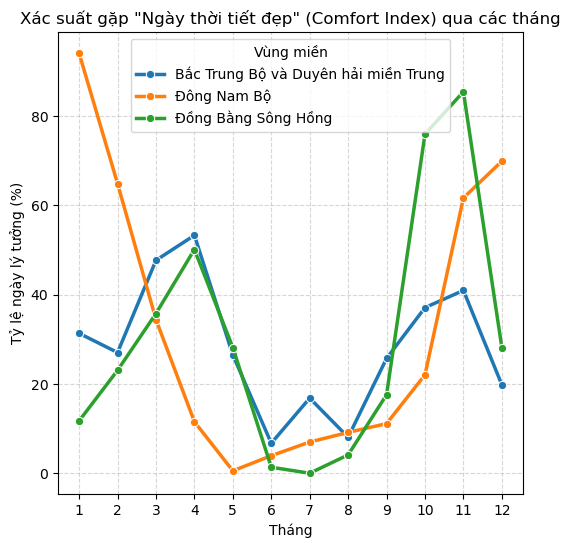

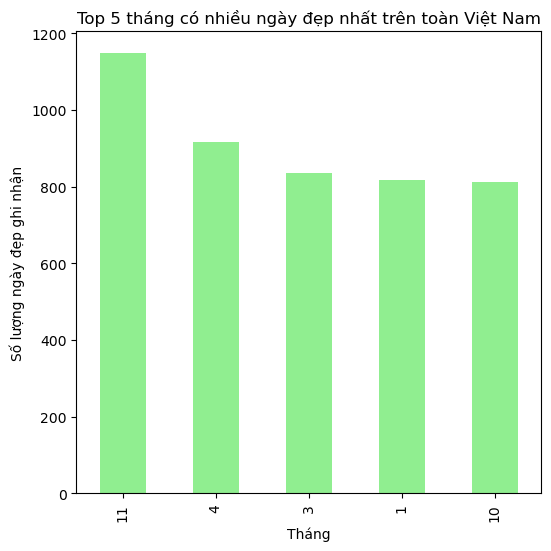

In [22]:
plt.figure(figsize=(6, 6))
sns.lineplot(
    data=subset_comfort, 
    x='month', 
    y='ideal_pct', 
    hue='location.region', 
    marker='o', 
    linewidth=2.5
)

plt.title('Xác suất gặp "Ngày thời tiết đẹp" (Comfort Index) qua các tháng')
plt.xlabel('Tháng')
plt.ylabel('Tỷ lệ ngày lý tưởng (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(1, 13)) # Đảm bảo hiện đủ 12 tháng
plt.legend(title='Vùng miền')
plt.show()

# Biểu đồ phụ: Top 5 tháng tuyệt vời nhất cả nước
top_months = df[df['is_ideal_day']].groupby('month').size().sort_values(ascending=False)
plt.figure(figsize=(6, 6))
top_months.head(5).plot(kind='bar', color='lightgreen')
plt.title('Top 5 tháng có nhiều ngày đẹp nhất trên toàn Việt Nam')
plt.xlabel('Tháng')
plt.ylabel('Số lượng ngày đẹp ghi nhận')
plt.show()

### Phân tích Xu hướng Thời tiết & Thời điểm Du lịch Lý tưởng tại Việt Nam

1. Phân tích Xu hướng theo Vùng (Dựa trên Line Chart):

- Quan sát: Biểu đồ đường cho thấy sự biến động mạnh mẽ về **Độ thoải mái (Comfort Index)** giữa các vùng miền, phản ánh rõ rệt sự đa dạng khí hậu của Việt Nam.

- Hiện tượng "Hố sâu mùa hè" (The Summer Dip):

    - Quan sát: Hầu hết các đường biểu diễn đều lao dốc mạnh trong giai đoạn **tháng 5 đến tháng 8**, chạm đáy cực thấp *(dưới 20%, thậm chí gần 0%)*.

    - Lý giải:

        - Miền Bắc & Miền Trung: Chịu nắng nóng gay gắt, nhiệt độ thường xuyên **> 30°C**, vượt ngưỡng lý tưởng **28°C**.

        - Miền Nam: Bước vào cao điểm **mùa mưa**, vi phạm tiêu chí lượng mưa lý tưởng *(< 5mm/ngày)*.

    - Kết luận: **Du lịch vào giữa mùa hè (tháng 6–7) có xác suất gặp thời tiết “đẹp” thấp nhất trong năm.**

- Sự trỗi dậy vào Mùa Thu – Đông (The Autumn–Winter Peak):

    - Quan sát: Các đường biểu diễn bắt đầu tăng mạnh từ **tháng 10** và đạt đỉnh vào **tháng 11, 12 và tháng 1**.

    - Đặc biệt:

        - Một số vùng *(khả năng là Tây Nguyên hoặc các vùng núi)* đạt tỷ lệ ngày đẹp rất cao **(> 60–70%)**.

        - Nguyên nhân đến từ **nhiệt độ mát mẻ (20–25°C)** và **mùa mưa đã kết thúc**.

2. Phân tích "Thời điểm vàng" Quốc gia (Dựa trên Bar Chart):

- Quan sát: Biểu đồ **“Top 5 tháng có nhiều ngày đẹp nhất”** đưa ra câu trả lời trực tiếp cho câu hỏi: *“Nên đi du lịch Việt Nam vào tháng mấy?”*

- Quán quân – Tháng 11 & 12:

    - Đây là hai cột cao nhất trên biểu đồ.

    - Tháng 11 là thời điểm giao mùa lý tưởng:

        - Miền Bắc: Chớm đông, **se lạnh – khô ráo**.

        - Miền Trung: **Mưa giảm rõ rệt**.

        - Miền Nam: Bắt đầu **mùa khô**, thời tiết mát mẻ nhất trong năm.

- Á quân – Tháng 1 & 3:

    - Giai đoạn đầu năm, **trước khi nắng nóng quay trở lại (tháng 4–5)**.

    - Điều kiện thời tiết nhìn chung **ổn định và dễ chịu**, phù hợp cho du lịch.

3. Kết luận & Khuyến nghị (Conclusion & Recommendation):

- Thời điểm vàng (Golden Time):

    - **Tháng 11 & Tháng 12** là lựa chọn tối ưu nhất cho các chuyến **du lịch xuyên Việt**.

    - Xác suất gặp thời tiết thuận lợi cao nhất trên phạm vi toàn quốc *(không quá nóng, không mưa lớn, độ ẩm vừa phải)*.

- Tránh rủi ro:

    - Du khách nên cân nhắc kỹ khi lên kế hoạch vào **tháng 6 & 7**.

    - Đây là giai đoạn các chỉ số thoải mái *(nhiệt độ/độ ẩm)* ở mức **tệ nhất**, trừ trường hợp du lịch biển để tránh nóng.

**Câu hỏi 3:** *Phân tích sự ảnh hưởng của Địa hình và Vùng miền đến Biên độ nhiệt và Độ ẩm – Tìm kiếm vùng khí hậu ổn định cho nông nghiệp*

**1. The Question**

- Địa hình (Đồng bằng, Miền núi, Ven biển) và Vùng miền ảnh hưởng như thế nào đến Biên độ nhiệt ngày (Diurnal Temperature Range - DTR) và sự biến động độ ẩm tại Việt Nam? Khu vực nào có khí hậu ổn định nhất (biên độ nhiệt thấp, độ ẩm ổn định) phù hợp cho các loại cây trồng nhạy cảm?

**2. Motivation & Benefits**

- Lý do: 
    - Biên độ nhiệt (chênh lệch nhiệt độ giữa ngày và đêm) là yếu tố sống còn trong nông nghiệp. Một số loại cây trồng cần biên độ nhiệt lớn để tích lũy đường (như trái cây vùng cao), trong khi số khác lại cần sự ổn định để tránh sốc nhiệt.

- Lợi ích: 
    - Kết quả nghiên cứu giúp các nhà quy hoạch nông nghiệp xác định được vùng canh tác tối ưu cho từng loại cây trồng đặc thù dựa trên sự kết hợp giữa địa hình và khí hậu vùng miền.

- Stakeholders: Nhà nông, doanh nghiệp nông nghiệp, các nhà khí hậu học và cơ quan quy hoạch vùng.

### A. Preprocessing

- Written Explanation:

    - Tính toán Biên độ nhiệt (DTR): Tạo cột mới temp_range bằng hiệu số giữa day.maxtemp_c và day.mintemp_c.

    - Lọc dữ liệu: Loại bỏ các giá trị biên độ nhiệt không hợp lệ (nhỏ hơn hoặc bằng 0).

    - Gom nhóm đa chiều: Sử dụng đồng thời location.region (Vùng miền) và location.terrain (Địa hình) làm tiêu chí nhóm để quan sát các tiểu vùng khí hậu.

    - Tổng hợp chỉ số: Tính giá trị trung bình (mean) và độ lệch chuẩn (std) cho biên độ nhiệt và độ ẩm để phục vụ bước phân tích độ ổn định.

In [23]:
# 1. Tính biên độ nhiệt ngày
df['temp_range'] = df['day.maxtemp_c'] - df['day.mintemp_c']

# 2. Lọc dữ liệu sạch
df_q3 = df[df['temp_range'] > 0].copy()

# 3. Gom nhóm theo Vùng miền và Địa hình
# Việc gộp cả 2 yếu tố giúp phân tích sâu hơn sự khác biệt vùng miền
region_terrain_stats = df_q3.groupby(['location.region', 'location.terrain']).agg({
    'temp_range': ['mean', 'std'],
    'day.avghumidity': ['mean', 'std']
}).reset_index()

# 4. Làm sạch tên cột (Flatten MultiIndex)
region_terrain_stats.columns = ['Region', 'Terrain', 'Avg_DTR', 'Std_DTR', 'Avg_Humidity', 'Std_Humidity']

# 5. Loại bỏ các cặp Vùng-Địa hình không có dữ liệu
region_terrain_stats = region_terrain_stats.dropna()

print("Thống kê khí hậu theo Vùng miền và Địa hình:")
display(region_terrain_stats)

Thống kê khí hậu theo Vùng miền và Địa hình:


,Region,Terrain,Avg_DTR,Std_DTR,Avg_Humidity,Std_Humidity
0,Bắc Trung Bộ và Duyên hải miền Trung,ven biển,6.154768,2.623207,80.298463,8.116111
1,Trung du và miền núi Bắc Bộ,miền núi,7.697856,3.220835,77.102313,14.403034
2,Trung du và miền núi Bắc Bộ,ven biển,4.366993,1.634497,78.320293,10.950763
3,Tây Nguyên,miền núi,9.481711,3.516902,80.217604,11.862639
4,Đông Nam Bộ,miền núi,8.191687,2.578499,78.657702,10.428336
5,Đông Nam Bộ,ven biển,3.128362,0.924093,78.286064,4.327163
6,Đông Nam Bộ,đồng bằng,8.025611,2.462047,70.714548,10.908171
7,Đồng Bằng Sông Cửu Long,ven biển,6.952323,2.455760,75.750961,8.829257
8,Đồng Bằng Sông Cửu Long,đồng bằng,7.807742,2.489031,74.106764,9.834796
9,Đồng Bằng Sông Hồng,miền núi,7.251345,2.707842,74.381418,12.581158


### B. Analysis
- Written Explanation:
    - Phương pháp: Tính toán Hệ số biến động (Coefficient of Variation - CV) cho độ ẩm. CV được tính bằng tỷ số giữa Độ lệch chuẩn và Giá trị trung bình ($CV = \frac{\sigma}{\mu} \times 100$).
    - Chỉ số ổn định: Một khu vực được coi là "ổn định" nếu có Avg_DTR thấp (nhiệt độ ngày đêm không chênh lệch nhiều) và Humidity_CV thấp (độ ẩm duy trì đều đặn).
    - Kỳ vọng: Các vùng ven biển miền Trung và miền Nam sẽ thể hiện tính ổn định cao hơn các vùng núi phía Bắc và Tây Nguyên.

In [24]:
# Tính Hệ số biến động của Độ ẩm (đo lường mức độ biến động % )
region_terrain_stats['Humidity_CV'] = (region_terrain_stats['Std_Humidity'] / region_terrain_stats['Avg_Humidity']) * 100

# Sắp xếp để tìm ra tiểu vùng có biên độ nhiệt thấp và độ ẩm ổn định nhất
stable_zones = region_terrain_stats.sort_values(by=['Avg_DTR', 'Humidity_CV'])

print("Top 10 khu vực có khí hậu ổn định nhất:")
display(stable_zones.head(10))

Top 10 khu vực có khí hậu ổn định nhất:


,Region,Terrain,Avg_DTR,Std_DTR,Avg_Humidity,Std_Humidity,Humidity_CV
5,Đông Nam Bộ,ven biển,3.128362,0.924093,78.286064,4.327163,5.527373
2,Trung du và miền núi Bắc Bộ,ven biển,4.366993,1.634497,78.320293,10.950763,13.982026
10,Đồng Bằng Sông Hồng,ven biển,6.072594,2.138181,75.404568,11.043193,14.645257
0,Bắc Trung Bộ và Duyên hải miền Trung,ven biển,6.154768,2.623207,80.298463,8.116111,10.107430
11,Đồng Bằng Sông Hồng,đồng bằng,6.829549,2.473045,74.205379,11.894646,16.029359
7,Đồng Bằng Sông Cửu Long,ven biển,6.952323,2.455760,75.750961,8.829257,11.655637
9,Đồng Bằng Sông Hồng,miền núi,7.251345,2.707842,74.381418,12.581158,16.914383
1,Trung du và miền núi Bắc Bộ,miền núi,7.697856,3.220835,77.102313,14.403034,18.680418
8,Đồng Bằng Sông Cửu Long,đồng bằng,7.807742,2.489031,74.106764,9.834796,13.271117
6,Đông Nam Bộ,đồng bằng,8.025611,2.462047,70.714548,10.908171,15.425639


### C. Results & Interpretation

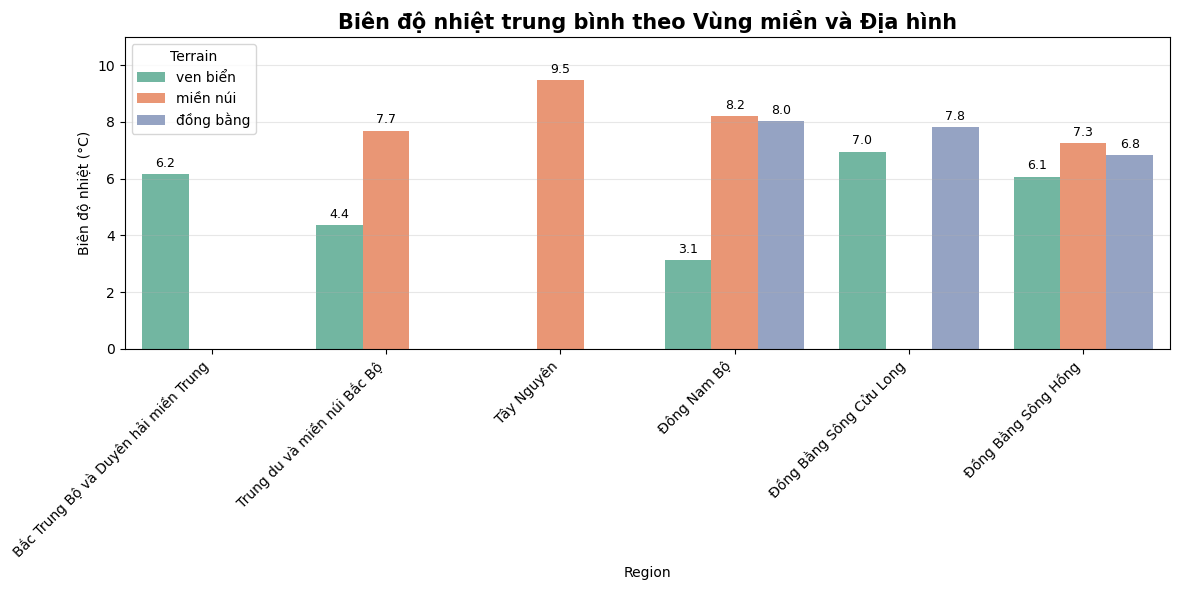

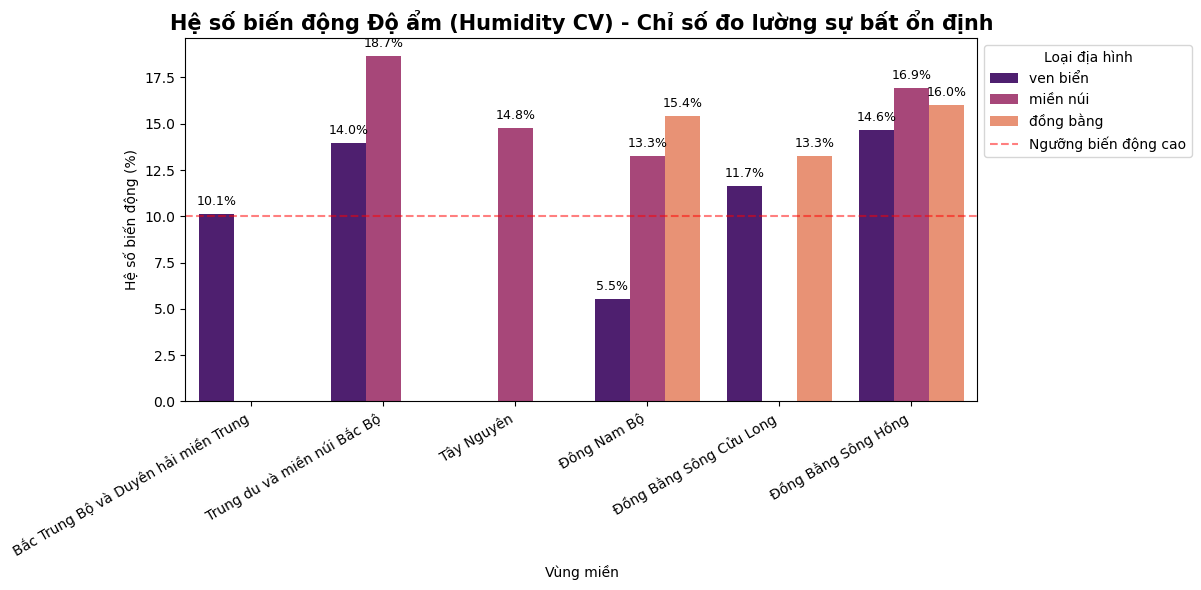

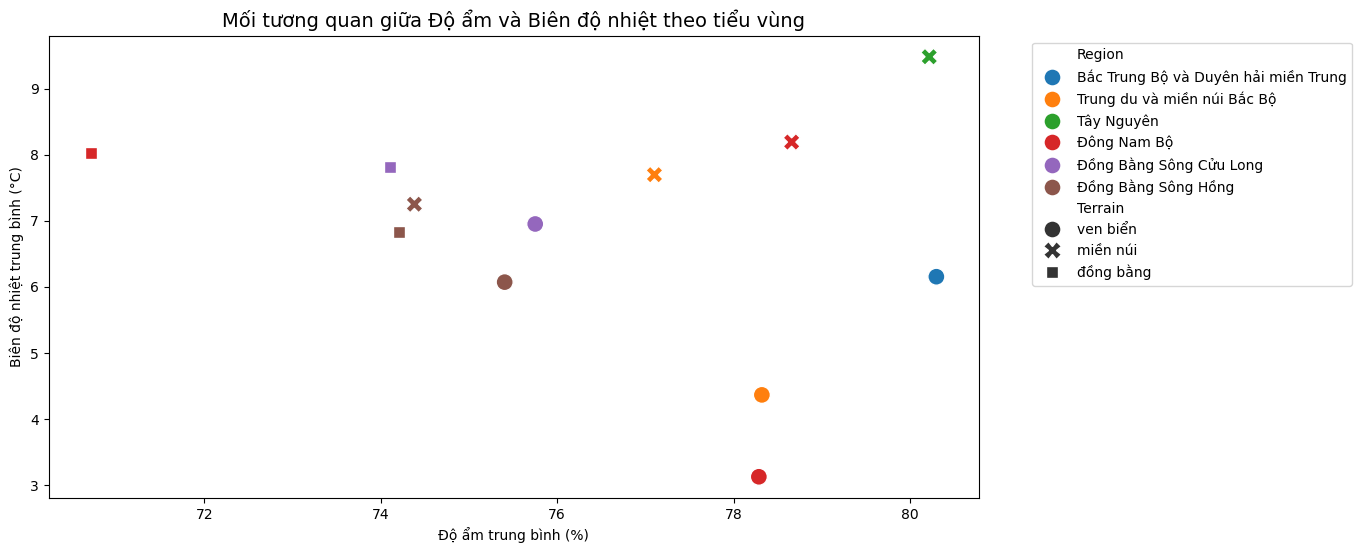

In [25]:
# Biểu đồ 1: So sánh Biên độ nhiệt theo Vùng và Địa hình
plt.figure(figsize=(12, 6))

# Gán biểu đồ vào biến 'ax' để thao tác thêm số liệu
ax = sns.barplot(data=region_terrain_stats, x='Region', y='Avg_DTR', hue='Terrain', palette='Set2')

# Thêm số liệu trên từng cột
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3, fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.title('Biên độ nhiệt trung bình theo Vùng miền và Địa hình', fontsize=15, fontweight='bold')
plt.ylabel('Biên độ nhiệt (°C)')
plt.grid(axis='y', alpha=0.3)

# Nới rộng khoảng cách phía trên để không bị mất số liệu ở các cột cao nhất
plt.ylim(0, region_terrain_stats['Avg_DTR'].max() + 1.5)

plt.tight_layout()
plt.show()

# Biểu đồ 2: BIẾN ĐỘNG ĐỘ ẨM (CV)
plt.figure(figsize=(12, 6))
ax2 = sns.barplot(data=region_terrain_stats, x='Region', y='Humidity_CV', hue='Terrain', palette='magma')
plt.title('Hệ số biến động Độ ẩm (Humidity CV) - Chỉ số đo lường sự bất ổn định', fontsize=15, fontweight='bold')
plt.xlabel('Vùng miền')
plt.ylabel('Hệ số biến động (%)')
plt.xticks(rotation=30, ha='right')
plt.axhline(10, ls='--', color='red', alpha=0.5, label='Ngưỡng biến động cao') # Đường tham chiếu
plt.legend(title='Loại địa hình', bbox_to_anchor=(1, 1))

for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(format(p.get_height(), '.1f') + '%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=9)
plt.tight_layout()
plt.show()

# Biểu đồ 3: Scatter plot thể hiện sự tương quan giữa Độ ẩm và Biên độ nhiệt
plt.figure(figsize=(12, 6))
sns.scatterplot(data=region_terrain_stats, x='Avg_Humidity', y='Avg_DTR', 
                hue='Region', style='Terrain', s=150)
plt.title('Mối tương quan giữa Độ ẩm và Biên độ nhiệt theo tiểu vùng', fontsize=14)
plt.xlabel('Độ ẩm trung bình (%)')
plt.ylabel('Biên độ nhiệt trung bình (°C)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Written Analysis

**Explicit Answer with Evidence:**
- Dựa trên kết quả phân tích, địa hình và vùng miền có tác động rõ rệt đến khí hậu. Khu vực có khí hậu ổn định nhất là các vùng **Ven biển phía Nam**, trong khi các vùng **Miền núi** (đặc biệt là Tây Nguyên và phía Đông) có sự biến động nhiệt độ và độ ẩm mạnh nhất.

**Specific Numbers & Patterns:**
* **Vùng ổn định nhất:** Tiểu vùng **Ven biển thuộc Đông Nam Bộ** ghi nhận mức độ ổn định kỷ lục với biên độ nhiệt ngày trung bình thấp nhất chỉ $3.1^\circ C$ và hệ số biến động độ ẩm ($CV$) cực thấp ở mức $5.5\%$.
* **Vùng biến động nhất:** **Tây Nguyên (Địa hình Miền núi)** có biên độ nhiệt ngày trung bình cao nhất, lên tới $9.5^\circ C$. Trong khi đó, **Trung du và miền núi Bắc Bộ** có mức độ biến động độ ẩm cao nhất với $CV \approx 18.7\%$.
* **Tác động địa hình:** Trong cùng một khu vực như Đồng Bằng Sông Cửu Long, địa hình **Ven biển** có biên độ nhiệt ($7^\circ C$) thấp hơn đáng kể so với vùng **Đồng bằng** ($7.8^\circ C$), minh chứng cho vai trò điều hòa khí hậu của đại dương.

**Practical Meaning & Implications:**
* **Nông nghiệp nhạy cảm:** Vùng Ven biển Đông Nam Bộ là lựa chọn tối ưu cho các loại cây trồng nhạy cảm với sốc nhiệt hoặc các mô hình nông nghiệp công nghệ cao cần môi trường kiểm soát ổn định.
* **Cây đặc sản:** Biên độ nhiệt lớn tại Tây Nguyên ($> 9^\circ C$) tuy khắc nghiệt nhưng lại là điều kiện cần thiết để các loại cây như Cà phê, Hồ tiêu tích lũy hương vị và các loại trái cây tích lũy độ đường cao.
* **Quản lý rủi ro:** Các vùng miền núi phía Bắc với biến động độ ẩm cao ($\approx 18.7\%$) cần hệ thống dự báo và tưới tiêu linh hoạt hơn để ứng phó với sự thay đổi trạng thái khí quyển đột ngột.

**Surprises or Unexpected Findings:**
- Mặc dù cả hai đều là địa hình miền núi, nhưng **Miền núi phía Bắc** có độ biến động độ ẩm cao hơn gần $1.3$ lần so với **Tây Nguyên**. Điều này có thể giải thích bởi ảnh hưởng của các đợt không khí lạnh đột ngột từ phương Bắc tràn về, trong khi Tây Nguyên chịu ảnh hưởng ổn định hơn của chế độ gió mùa nhiệt đới.

**Limitations:**
* Dữ liệu chỉ tập trung trong khoảng thời gian hơn 1 năm ($2024$ - $2025$), do đó chưa phản ánh được các chu kỳ khí hậu dài hạn hoặc các hiện tượng cực đoan hiếm gặp như El Nino mạnh.
* Phân tích dựa trên giá trị trung bình hàng ngày nên có thể bỏ sót các biến động cực ngắn trong ngày (ví dụ: các cơn mưa dông nhiệt bất ngờ làm giảm nhiệt độ đột ngột trong vài giờ).

**Câu hỏi 4:** *Phân tích Chỉ số Nhiệt (Heat Index) và Nguy cơ Sốc nhiệt – Đánh giá sự khắc nghiệt của khí hậu đối với sức khỏe cộng đồng*

**1. The Question**

- Sự kết hợp giữa nhiệt độ trung bình và độ ẩm tạo ra Chỉ số Nhiệt (Heat Index) như thế nào tại các Vùng miền của Việt Nam? Dựa trên các ngưỡng cảnh báo của NOAA (National Oceanic and Atmospheric Administration), những khu vực nào có tần suất xuất hiện ngưỡng 'Nguy hiểm' (Danger) cao nhất, và sự khác biệt giữa nhiệt độ thực tế với nhiệt độ cảm nhận là bao nhiêu?

**2. Motivation & Benefits**

- Lý do: 
    - Ở các nước nhiệt đới như Việt Nam, độ ẩm cao thường làm cho cảm giác nóng bức trở nên tồi tệ hơn vì mồ hôi không thể bay hơi nhanh. Chỉ số nhiệt là thước đo chính xác hơn về nguy cơ sốc nhiệt và kiệt sức so với việc chỉ nhìn vào nhiệt độ đơn thuần.
- Lợi ích: 
    - Cung cấp bằng chứng thực tế về mức độ khắc nghiệt của thời tiết, hỗ trợ các khuyến cáo về y tế công cộng và an toàn lao động ngoài trời.

- Stakeholders: Bộ Y tế, các đơn vị quản lý an toàn lao động, người dân và khách du lịch.

### A. Preprocessing

- Written Explanation:

    - Chuyển đổi đơn vị: Công thức chuẩn của Heat Index yêu cầu nhiệt độ tính theo độ Fahrenheit (°F). Do đó, bước đầu tiên là chuyển đổi `day.avgtemp_c` sang °F.

    - Tính toán Chỉ số Nhiệt (Heat Index): Áp dụng công thức đa thức của Rothfusz (sử dụng trong mô hình của NOAA) kết hợp giữa nhiệt độ và `day.avghumidity`.

    - Phân loại ngưỡng nguy hiểm: Dựa trên giá trị Heat Index thu được, tiến hành phân loại thành 4 mức độ:
        - Caution (27-32°C): Mệt mỏi nếu hoạt động lâu.
        - Extreme Caution (32-41°C): Có thể bị sốc nhiệt/kiệt sức.
        - Danger (41-54°C): Nguy cơ sốc nhiệt rất cao.
        - Extreme Danger (>54°C): Sốc nhiệt cực kỳ nguy hiểm.

    - Chuyển đổi ngược: Chuyển Heat Index về lại độ Celsius (°C) để dễ dàng so sánh và trực quan hóa theo thói quen sử dụng tại Việt Nam.

In [26]:
# Hàm tính Heat Index (Công thức Rothfusz của NOAA)
def calculate_heat_index(temp_c, rh):
    T = (temp_c * 9/5) + 32  # Chuyển sang Fahrenheit để tính toán
    HI = -42.379 + 2.04901523*T + 10.14333127*rh - 0.22475541*T*rh \
         - 0.00683783*T*T - 0.05481717*rh*rh + 0.00122874*T*T*rh \
         + 0.00085282*T*rh*rh - 0.00000199*T*T*rh*rh
    return (HI - 32) * 5/9  # Chuyển ngược kết quả về Celsius

# Tạo bản sao df_hi để không làm hỏng dữ liệu gốc
df_hi = df.copy()

# Làm sạch tên vùng miền (loại bỏ ký tự lạ)
df_hi['location.region'] = df_hi['location.region'].str.replace(r'\[.*\]', '', regex=True).str.strip()

# Tính toán Chỉ số nhiệt và mức chênh lệch cảm nhận
df_hi['heat_index_c'] = df_hi.apply(lambda x: calculate_heat_index(x['day.avgtemp_c'], x['day.avghumidity']), axis=1)
df_hi['perceived_diff'] = df_hi['heat_index_c'] - df_hi['day.avgtemp_c']

# Phân loại mức độ rủi ro nhiệt
def get_risk_level(hi):
    if hi < 27: return 'Safe'
    if hi < 32: return 'Caution'
    if hi < 41: return 'Extreme Caution'
    if hi < 54: return 'Danger'
    return 'Extreme Danger'

df_hi['risk_level'] = df_hi['heat_index_c'].apply(get_risk_level)

print("Đã tạo thành công biến df_hi")
display(df_hi[['location.name', 'heat_index_c', 'risk_level']].head())

Đã tạo thành công biến df_hi


,location.name,heat_index_c,risk_level
0,An Giang,33.820935,Extreme Caution
1,Bà Rịa-Vũng Tàu,32.783458,Extreme Caution
2,Bắc Giang,31.646611,Caution
3,Bắc Kạn,25.900564,Safe
4,Bạc Liêu,33.761244,Extreme Caution


### B. Analysis

- Written Explanation:

    - Phân tích tần suất: Thống kê tỷ lệ phần trăm các ngày rơi vào ngưỡng "Caution", "Extreme Caution" và "Danger" tại mỗi Vùng miền (`location.region`).

    - So sánh mức độ "đánh lừa" của nhiệt độ: Phân tích mức chênh lệch trung bình (`perceived_diff`) giữa nhiệt độ thực tế và nhiệt độ cảm nhận để xem khu vực nào có độ ẩm gây ảnh hưởng lớn nhất.

    - Trực quan hóa: Sử dụng Heatmap để thể hiện mức độ nguy hiểm theo vùng và biểu đồ Bar chart để so sánh nhiệt độ thực tế với nhiệt độ cảm nhận.

In [27]:
# Tạo bảng thống kê tỷ lệ rủi ro (risk_stats)
# Tính tỷ lệ phần trăm số ngày theo từng mức độ rủi ro tại mỗi vùng
risk_stats = pd.crosstab(df_hi['location.region'], df_hi['risk_level'], normalize='index') * 100

# Đảm bảo các cột rủi ro được sắp xếp theo thứ tự mức độ tăng dần
risk_order = ['Safe', 'Caution', 'Extreme Caution', 'Danger']
available_cols = [c for c in risk_order if c in risk_stats.columns]
risk_stats = risk_stats[available_cols]

# Tính dữ liệu trung bình tổng hợp (avg_comparison)
# CẬP NHẬT: Thêm 'day.avghumidity' và 'perceived_diff' để khớp với phần giải thích
avg_comparison = df_hi.groupby('location.region').agg({
    'day.avgtemp_c': 'mean',
    'day.avghumidity': 'mean',     # Thêm độ ẩm trung bình
    'heat_index_c': 'mean',
    'perceived_diff': 'mean'      # Thêm mức chênh lệch trung bình
}).sort_values(by='heat_index_c')

print("- Tỷ lệ rủi ro nhiệt độ theo vùng miền (%):")
display(risk_stats)

print("\n- So sánh nhiệt độ thực tế, độ ẩm và chỉ số nhiệt cảm nhận:")
display(avg_comparison)

- Tỷ lệ rủi ro nhiệt độ theo vùng miền (%):


risk_level,Safe,Caution,Extreme Caution,Danger
location.region,,,,
Bắc Trung Bộ và Duyên hải miền Trung,43.538247,28.676214,27.785540,0.000000
Trung du và miền núi Bắc Bộ,61.299336,25.619979,12.626615,0.454069
Tây Nguyên,85.134474,13.887531,0.977995,0.000000
Đông Nam Bộ,13.814181,52.852486,33.333333,0.000000
Đồng Bằng Sông Cửu Long,16.287380,53.676885,30.035734,0.000000
Đồng Bằng Sông Hồng,44.241885,27.812361,27.923522,0.022232



- So sánh nhiệt độ thực tế, độ ẩm và chỉ số nhiệt cảm nhận:


,day.avgtemp_c,day.avghumidity,heat_index_c,perceived_diff
location.region,,,,
Tây Nguyên,22.778875,80.217604,23.161632,0.382756
Trung du và miền núi Bắc Bộ,22.255920,77.189312,26.176603,3.920683
Bắc Trung Bộ và Duyên hải miền Trung,25.565246,80.298463,27.815025,2.249778
Đồng Bằng Sông Hồng,24.565318,74.548244,28.615306,4.049988
Đồng Bằng Sông Cửu Long,27.565676,74.992101,30.325940,2.760264
Đông Nam Bộ,27.778729,73.300326,30.507746,2.729018


### C. Results & Interpretation

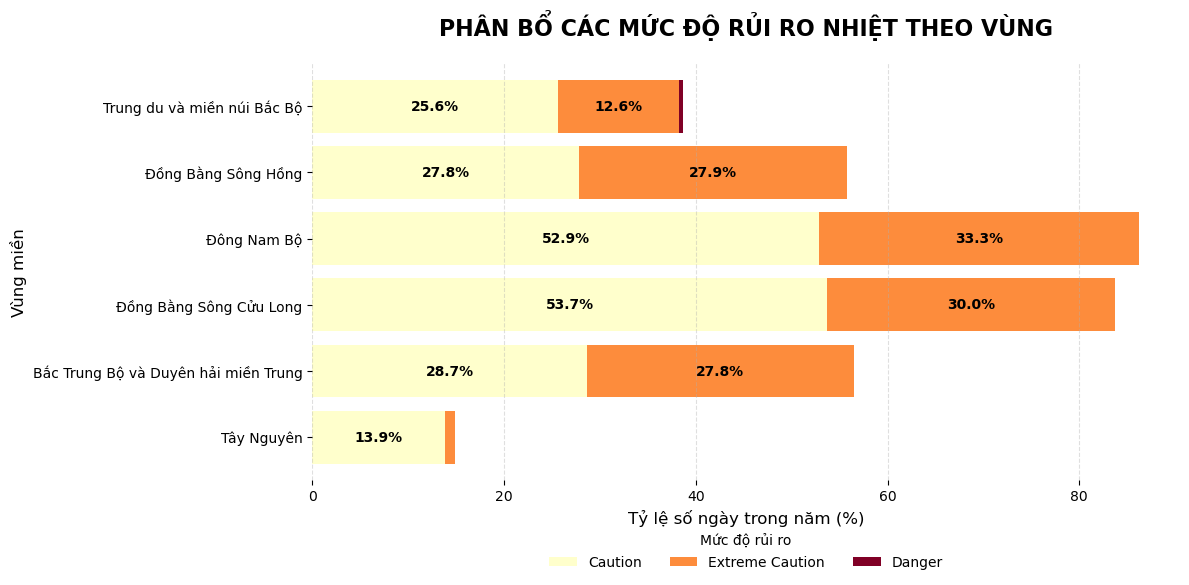

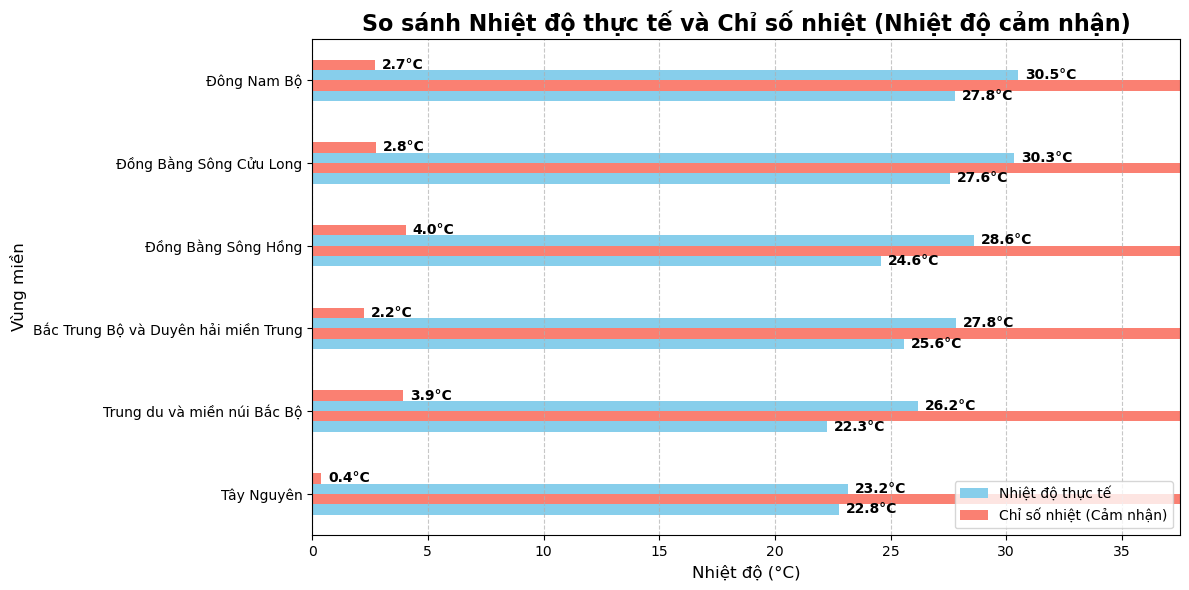

In [28]:
# Sắp xếp dữ liệu: Ưu tiên đưa các vùng có tỷ lệ "Danger" và "Extreme Caution" cao lên đầu
# Giúp người xem nhận diện ngay vùng nào khắc nghiệt nhất
risk_stats_sorted = risk_stats.sort_values(by=['Danger', 'Extreme Caution'], ascending=True)

# Tạo biểu đồ cột ngang (kind='barh')
fig, ax1 = plt.subplots(figsize=(12, 6)) # Tăng chiều cao để các hàng thoáng hơn

risk_stats_plot = risk_stats_sorted[['Caution', 'Extreme Caution', 'Danger']].plot(
    kind='barh', 
    stacked=True, 
    ax=ax1, 
    colormap='YlOrRd', # Tông màu cảnh báo từ Vàng đến Đỏ
    width=0.8
)

# Cải tiến nhãn số liệu
for container in ax1.containers:
    # Chỉ hiển thị số nếu tỷ lệ > 5% để tránh đè chữ ở các đoạn quá nhỏ
    labels = [f'{v:.1f}%' if v > 5 else '' for v in container.datavalues]
    ax1.bar_label(container, labels=labels, label_type='center', fontsize=10, fontweight='bold', color='black')

# Việt hóa và tinh chỉnh thẩm mỹ
plt.title('PHÂN BỔ CÁC MỨC ĐỘ RỦI RO NHIỆT THEO VÙNG', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tỷ lệ số ngày trong năm (%)', fontsize=12)
plt.ylabel('Vùng miền', fontsize=12)

# Đặt chú thích (Legend) ở phía dưới biểu đồ cho thoáng
plt.legend(title='Mức độ rủi ro', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, frameon=False)

plt.grid(axis='x', linestyle='--', alpha=0.4) # Chỉ để lưới dọc để gióng tỷ lệ %
sns.despine(left=True, bottom=True) # Xóa khung viền cho biểu đồ hiện đại

plt.tight_layout()
plt.show()

# Biểu đồ 2: So sánh Nhiệt độ thực tế và Chỉ số nhiệt
fig, ax2 = plt.subplots(figsize=(12, 6))
avg_comparison.plot(kind='barh', ax=ax2, color=['skyblue', 'salmon'])

# Thêm số liệu vào cuối mỗi thanh ngang
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f°C', padding=5, fontsize=10, fontweight='bold')

plt.title('So sánh Nhiệt độ thực tế và Chỉ số nhiệt (Nhiệt độ cảm nhận)', fontsize=16, fontweight='bold')
plt.xlabel('Nhiệt độ (°C)', fontsize=12)
plt.ylabel('Vùng miền', fontsize=12)
plt.legend(['Nhiệt độ thực tế', 'Chỉ số nhiệt (Cảm nhận)'], loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Nới rộng trục x để không bị đè số liệu
ax2.set_xlim(0, avg_comparison['heat_index_c'].max() + 7)

plt.tight_layout()
plt.show()

#### Written Analysis

**Explicit Answer with Evidence:**
- Kết quả phân tích cho thấy độ ẩm cao đặc trưng của khí hậu Việt Nam là tác nhân chính đẩy Chỉ số Nhiệt ($Heat$ $Index - HI$) lên mức cao hơn đáng kể so với nhiệt độ môi trường thực tế. Khu vực chịu ảnh hưởng nặng nề nhất bởi sự khắc nghiệt này là **Đông Nam Bộ** và **Đồng bằng sông Cửu Long**, nơi tần suất xuất hiện các ngưỡng nguy cơ sức khỏe thường xuyên nằm ở mức báo động.

**Specific Numbers & Patterns:**
* **Mức chênh lệch nhiệt độ:** Tại **Đồng bằng sông Cửu Long**, người dân cảm thấy nóng hơn thực tế trung bình khoảng $2.8^\circ C$, nhưng vào những ngày nóng ẩm đỉnh điểm, mức chênh lệch cảm nhận ($perceived\_diff$) vọt lên tới $6.6^\circ C$.
* **Vai trò của độ ẩm:** Khu vực miền Tây Nam Bộ có độ ẩm trung bình duy trì ở mức cao xấp xỉ $74.96\%$. Chính lượng hơi nước dồi dào này đã ngăn cản quá trình bay hơi mồ hôi, khiến chỉ số nhiệt luôn cao hơn nhiệt độ nền.
* **Tần suất nguy hiểm:** Theo dữ liệu, **Đông Nam Bộ** là khu vực có cấu trúc nhiệt độ khắc nghiệt với hơn $30\%$ số ngày trong năm rơi vào ngưỡng **Extreme Caution** ($41^\circ C \le HI < 54^\circ C$), cảnh báo nguy cơ sốc nhiệt rất cao nếu hoạt động cường độ mạnh.
* **Vùng có chênh lệch cao nhất:** Đáng chú ý, **Đồng bằng sông Hồng** ghi nhận mức chênh lệch cảm nhận trung bình cao nhất cả nước ($\sim 4^\circ C$), cho thấy sự kết hợp giữa nhiệt độ và độ ẩm tại đây tạo ra cảm giác oi bức cực kỳ khó chịu.
* **Khu vực an toàn:** **Tây Nguyên** là "vùng xanh" về sức khỏe nhiệt với hơn $80\%$ số ngày nằm trong ngưỡng **Safe**, nhờ lợi thế địa hình cao giúp nhiệt độ nền thấp.

**Practical Meaning & Implications:**
* **An toàn lao động:** Dữ liệu cho thấy các ngành nghề ngoài trời tại phía Nam cần có chế độ nghỉ ngơi nghiêm ngặt trong khung giờ từ $11:00$ đến $15:00$ khi chỉ số $HI$ chạm ngưỡng **Extreme Caution** để bảo vệ sức khỏe công nhân.
* **Y tế công cộng:** Ngành y tế nên sử dụng chỉ số $HI$ thay vì nhiệt độ thông thường để đưa ra các cảnh báo về mất nước và sốc nhiệt chính xác hơn, đặc biệt đối với nhóm người già và trẻ em.

**Surprises or Unexpected Findings:**
- Một phát hiện bất ngờ là mặc dù nhiệt độ thực tế tại **Đồng bằng sông Cửu Long** thường thấp hơn các tỉnh **Bắc Trung Bộ** (nơi có gió Lào nóng khô), nhưng do độ ẩm miền Tây rất cao, Chỉ số Nhiệt cảm nhận cuối cùng lại cao hơn. Điều này giải thích hiện tượng "nóng hầm" gây mệt mỏi kéo dài tại miền Nam so với cái nóng khô ở miền Trung.

**Limitations:**
* **Điều kiện môi trường:** Chỉ số nhiệt được tính toán dựa trên điều kiện trong bóng râm. Nếu tiếp xúc trực tiếp dưới ánh nắng mặt trời, nhiệt độ cảm nhận thực tế có thể tăng thêm khoảng $8^\circ C$ so với kết quả phân tích.
* **Dữ liệu thời gian:** Phân tích chỉ dựa trên tập dữ liệu của $1$ năm ($2024$-$2025$), do đó chưa phản ánh được các năm có hiện tượng $El$ $Ni\tilde{n}o$ cực đoan khi chỉ số nhiệt có thể đạt ngưỡng nguy hiểm hơn.

### 2.5 Project Summary

#### **Key Findings:**
* **Sự chênh lệch giữa nhiệt độ thực tế và nhiệt độ cảm nhận (Heat Index):** Phân tích cho thấy độ ẩm cao tại Việt Nam, đặc biệt là ở khu vực Miền Nam và Đồng bằng sông Cửu Long, làm tăng đáng kể nhiệt độ cảm nhận. Trong khi nhiệt độ thực tế có thể không quá cao, chỉ số Heat Index thường xuyên rơi vào ngưỡng "Extreme Caution" (Cần đặc biệt thận trọng), giải thích hiện tượng "nóng hầm" đặc trưng của khí hậu nhiệt đới.

* **Tiềm năng năng lượng tái tạo theo địa hình:** Có sự phân hóa rõ rệt về tiềm năng năng lượng; các vùng ven biển có chỉ số năng lượng gió (Wind Score) cao nhất, trong khi vùng Tây Nguyên và Nam Bộ lại sở hữu tiềm năng năng lượng mặt trời (Solar Score) tối ưu nhờ chỉ số UV và thời gian chiếu sáng dài.
* **Tính mùa vụ của độ thoải mái trong du lịch:** Chỉ số "Ngày lý tưởng" (Ideal Day) cho thấy một sự sụt giảm mạnh vào tháng 6 và tháng 7 trên cả ba miền. Đây là thời điểm thời tiết khắc nghiệt nhất (kết hợp giữa nhiệt độ đỉnh điểm và độ ẩm cao), gây bất lợi cho các hoạt động du lịch ngoài trời.
* **Hiệu năng dự báo của Machine Learning:** Các mô hình học máy dạng cây (Gradient Boosting, XGBoost) đạt độ chính xác cao trong việc dự báo nhiệt độ trung bình với sai số RMSE chỉ khoảng 1.5°C. Tuy nhiên, việc dự báo lượng mưa vẫn là một thách thức lớn do tính ngẫu nhiên và biến động cực đoan của các hiện tượng thiên tai.
* **Phát hiện bất ngờ nhất:** Mặc dù nhiệt độ thực tế tại các tỉnh Bắc Trung Bộ (nơi chịu ảnh hưởng của gió Lào) thường cao hơn, nhưng chỉ số nhiệt cảm nhận (Heat Index) tại Miền Tây lại thường xuyên cao hơn do độ ẩm rất lớn. Điều này cho thấy độ ẩm là yếu tố gây mệt mỏi và rủi ro sức khỏe lớn hơn cả nhiệt độ thuần túy trong bối cảnh khí hậu Việt Nam.

#### **Limitations:**
* **Hạn chế về dữ liệu (Dataset limitations):** Tập dữ liệu chỉ bao gồm khoảng 1 năm (2024-2025), do đó chưa phản ánh được các chu kỳ khí hậu dài hạn hoặc các hiện tượng cực đoan hiếm gặp như El Niño hay La Niña mạnh.
* **Hạn chế về phân tích (Analysis limitations):** Chỉ số nhiệt (Heat Index) trong dự án được tính toán dựa trên điều kiện trong bóng râm. Khi tiếp xúc trực tiếp dưới ánh nắng mặt trời, nhiệt độ cảm nhận thực tế có thể tăng thêm khoảng 8°C so với kết quả phân tích.
* **Hạn chế về phạm vi (Scope limitations):** Mô hình hiện tại chưa tích hợp được dữ liệu về áp suất khí quyển và độ cao so với mực nước biển (Altitude), vốn là những biến số quan trọng để dự báo bão và thời tiết vùng núi cao chính xác hơn.

#### **Future Directions (If You Had More Time):**
* **Câu hỏi mở rộng:** Nghiên cứu sâu hơn về mối tương quan giữa các chỉ số thời tiết và chất lượng không khí (AQI) tại các đô thị lớn của Việt Nam.
* **Phân tích chuyên sâu:** Áp dụng các mô hình Deep Learning (như LSTM - Long Short-Term Memory) để tận dụng tính chuỗi thời gian của dữ liệu thời tiết, thay vì chỉ sử dụng các mô hình bảng (tabular) truyền thống.

* **Phương pháp thay thế:** Tích hợp dữ liệu ảnh vệ tinh để theo dõi độ che phủ của mây theo thời gian thực, giúp cải thiện độ chính xác cho bài toán dự báo lượng mưa.
* **Dữ liệu bổ sung:** Thu thập dữ liệu lịch sử trong vòng 10 năm qua để xây dựng mô hình dự báo có khả năng nhận diện các xu hướng biến đổi khí hậu dài hạn tại Việt Nam.
* **Mở rộng ứng dụng:** Phát triển một ứng dụng hỗ trợ người dân và khách du lịch đưa ra cảnh báo về "ngưỡng nguy hiểm nhiệt độ" dựa trên tọa độ GPS thời gian thực.

## Phuc's Individual Reflections
1. Challenges & Difficulties Encountered
- **What specific obstacles did you face?** Khó khăn lớn nhất mà em gặp phải là bài toán Rain Prediction (Dự báo lượng mưa). Dữ liệu lượng mưa có tính chất phân phối rất lệch (skewed distribution) – số ngày không mưa hoặc mưa nhỏ chiếm đa số, trong khi các ngày bão (mưa cực lớn) lại là các điểm ngoại lai (outliers). Do đó, mô hình thường có xu hướng dự báo "an toàn" (dự báo lượng mưa thấp) để tối thiểu hóa sai số trung bình, dẫn đến việc thất bại trong việc bắt các đỉnh mưa (peak values) khi có bão hoặc áp thấp nhiệt đới.How did you overcome them?
- Để khắc phục, em đã không chỉ dựa vào các chỉ số khí tượng cơ bản mà chuyển sang tập trung vào Feature Engineering (Kỹ thuật đặc trưng): Tích hợp thêm các yếu tố địa lý như Địa hình (Terrain) và Tầm nhìn (Visibility) vì vùng núi và vùng ven biển có cơ chế mưa khác nhau. Chuyển đổi bài toán từ Chẩn đoán (Diagnostic) sang Dự báo (Forecasting) bằng cách tạo các Lag Features (Biến trễ) – sử dụng dữ liệu độ ẩm, gió của ngày hôm trước để dự đoán cho ngày hôm sau. Sử dụng các mô hình cây quyết định mạnh mẽ (Random Forest, Gradient Boosting) thay vì hồi quy tuyến tính đơn giản để bắt được tính phi tuyến tính của thời tiết.
- **What was most challenging and why?** Điều thách thức nhất là sự đánh đổi giữa Bias và Variance trong dự báo bão. Nếu cố gắng ép mô hình học các cơn bão lớn (như Yagi), mô hình rất dễ bị Overfitting (học vẹt) và dự báo sai lệch lớn vào những ngày bình thường. Việc cân chỉnh (tuning) mô hình để vừa đảm bảo độ chính xác tổng thể (R2 score), vừa không bỏ sót các cảnh báo thiên tai quan trọng là một bài toán tối ưu cực kỳ nan giải.

2. Learning & Growth
- **What have you learned?** Về mặt kỹ thuật, em đã nắm vững kỹ năng Feature Engineering, đặc biệt là kỹ thuật Cyclical Encoding (mã hóa chu kỳ). Trước đây em thường xử lý ngày/tháng như số tuyến tính, nhưng qua đồ án này, em hiểu rằng việc sử dụng hàm Sin/Cos để mô hình hóa tính chu kỳ của thời gian (ví dụ: tháng 12 rất gần tháng 1) là cực kỳ quan trọng để tăng độ chính xác cho mô hình Time-series. Ngoài ra, em cũng học được cách tích hợp API để kiểm chứng mô hình với dữ liệu thực tế (Real-time validation).
- **What surprised you most?** Điều làm em bất ngờ nhất là sự chênh lệch lớn về độ chính xác giữa các điều kiện thời tiết khác nhau. Sai số (MAE) trong dự báo mưa bão lớn hơn gấp nhiều lần so với mưa nhỏ. Điều này cho thấy rằng một mô hình có chỉ số tổng thể tốt ($R^2 \approx 0.4$) vẫn có thể "vô dụng" trong các tình huống khẩn cấp nếu không được xử lý chuyên biệt cho các giá trị cực đoan (Extreme events).
- **How has this project shaped your understanding of data science?** Đồ án này đã thay đổi tư duy của em từ "Model-centric" (tập trung tìm mô hình xịn nhất) sang "Data-centric" (tập trung vào chất lượng dữ liệu). Em nhận ra rằng việc hiểu bối cảnh dữ liệu (Domain Knowledge) – ví dụ như hiểu tại sao gió ẩm gặp núi lại gây mưa – quan trọng hơn nhiều so với việc chỉ đơn thuần chạy các thuật toán. Data Science không chỉ là những dòng code Python, mà là việc kể câu chuyện thực tế thông qua các con số và biến chúng thành giá trị sử dụng được (như cảnh báo bão sớm).

## Loi's Individual Reflections

### 1. Challenges & Difficulties Encountered
- **What specific obstacles did you face?**  
Khó khăn chính mà em gặp phải không nằm ở việc làm sạch dữ liệu, vì dataset ban đầu khá hoàn chỉnh và không có missing values, mà nằm ở khâu phân tích và diễn giải dữ liệu. Khi dữ liệu quá “sạch”, thách thức chuyển sang việc hiểu đúng ý nghĩa thống kê của các biến và xác định mối quan hệ thực sự quan trọng giữa chúng. Đặc biệt, trong giai đoạn Relationships & Correlation analysis, nhiều biến thời tiết có mức độ tương quan khác nhau, gây khó khăn trong việc lựa chọn biến phù hợp cho mô hình.

- **How did you overcome them?**  
Để giải quyết, em tập trung vào việc khám phá dữ liệu một cách có hệ thống thông qua trực quan hóa như histogram, boxplot và correlation heatmap thay vì chỉ dựa vào các chỉ số thống kê. Trong bài toán Regression cho Temperature, em thử nghiệm nhiều tập biến đầu vào khác nhau và so sánh hiệu quả giữa các mô hình để tránh việc lựa chọn biến mang tính chủ quan. Việc kết hợp giữa phân tích định lượng và trực quan giúp em hiểu rõ hơn vai trò của từng biến trong mô hình.

- **What was most challenging and why?**  
Điều thách thức nhất là diễn giải kết quả mô hình một cách hợp lý. Một số biến có tương quan cao với Temperature nhưng khi đưa vào mô hình hồi quy lại không cải thiện đáng kể hiệu suất. Điều này buộc em phải cân nhắc cả ý nghĩa thực tế của biến, thay vì chỉ dựa trên kết quả toán học.

### 2. Learning & Growth
- **What have you learned?**  
Thông qua đồ án, em học được cách thực hiện EDA một cách đầy đủ và có chiều sâu, ngay cả khi dữ liệu không gặp vấn đề về missing values. Em hiểu rõ hơn vai trò của correlation analysis trong việc định hướng mô hình hóa và cách xây dựng, đánh giá một mô hình hồi quy cho dữ liệu thực tế. Ngoài ra, em cũng cải thiện kỹ năng trình bày và giải thích kết quả phân tích bằng ngôn ngữ dễ hiểu.

- **What surprised you most?**  
Điều khiến em bất ngờ nhất là việc dữ liệu sạch không đồng nghĩa với bài toán đơn giản. Mặc dù không cần xử lý missing data, việc hiểu và khai thác mối quan hệ giữa các biến vẫn đòi hỏi nhiều suy nghĩ và thử nghiệm. Một mô hình có chỉ số đánh giá tốt vẫn có thể tồn tại nhiều hạn chế khi áp dụng vào các điều kiện khác nhau.

- **How has this project shaped your understanding of data science?**  
Đồ án này giúp em nhận ra rằng data science không chỉ là chạy mô hình hay tối ưu chỉ số, mà là một quá trình tư duy phân tích liên tục. Việc đặt câu hỏi, hiểu dữ liệu, lựa chọn phương pháp và thừa nhận giới hạn của kết quả đều quan trọng như nhau. Em hiểu rằng giá trị cốt lõi của data science nằm ở khả năng diễn giải và hỗ trợ ra quyết định, chứ không chỉ ở độ chính xác của mô hình.
